In [1]:
import numpy as np
import tifffile
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from ctxseg.segmentation.flow import flow_to_mask
from ctxseg.segmentation.utils import remove_small_instances, clean_up_mask
from ctxseg.segmentation.metrics import LabelMetrics, MultiLabelMetrics
from ctxseg.utils.plotting import show_images

import treescope
treescope.register_as_default()
treescope.basic_interactive_setup(autovisualize_arrays=True)

root = Path("dm_prediction_1step/")
dataset = 'cellpose'
n = 1 # number of predictions per input

## Evaluation

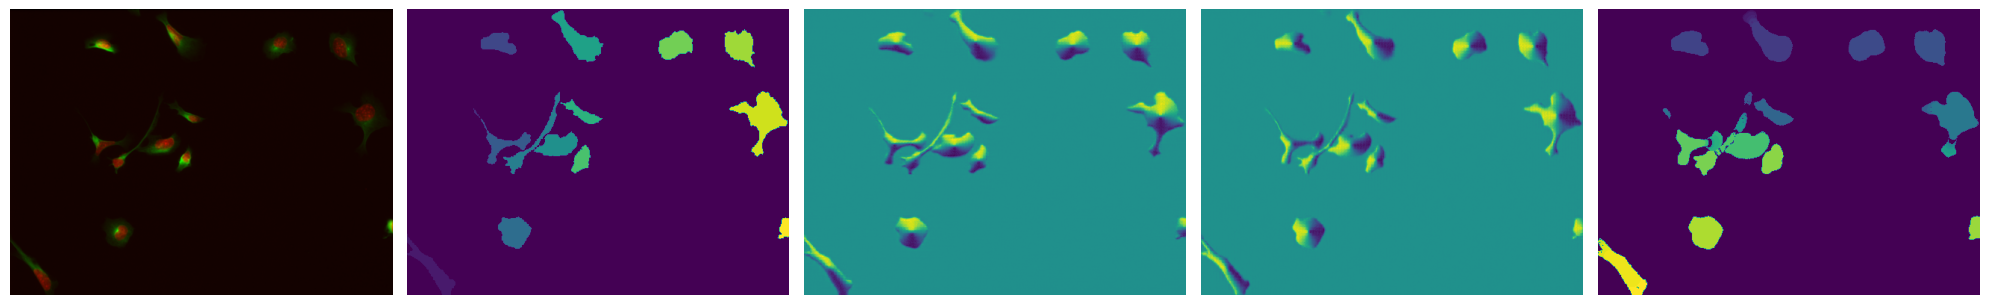

In [2]:
# Visualize one example
img = tifffile.imread(root/dataset/"20.tif")
gt = tifffile.imread(root/dataset/"20_label.tif")
pred = tifffile.imread(root/dataset/"20_pred.tif")

assert pred.shape[1] == n

label = flow_to_mask(np.moveaxis(pred, 0, -1))
show_images([img, gt, pred[0][0], pred[1][0], label[0]])

In [3]:
# inference parameters
params = dict(
    niter=1000,
    threshold=0.1,
    max_flow_err=0.,   
)

metric = MultiLabelMetrics(n)

ids = [fn.name.split("_label")[0] for fn in (root/dataset).glob("*_label*")]

for img_n in tqdm(ids):
    img = tifffile.imread(root/dataset/f"{img_n}.tif")
    gt = tifffile.imread(root/dataset/f"{img_n}_label.tif")
    pred = tifffile.imread(root/dataset/f"{img_n}_pred.tif")

    # gt = remove_small_instances(gt, 100) # hack correct test dataset error

    label = flow_to_mask(np.moveaxis(pred, 0, -1), **params)

    # optionally remove small cells
    label = np.stack([
        clean_up_mask(remove_small_instances(x, 100))
        for x in label
    ])

    tifffile.imwrite(root/dataset/f"{img_n}_output.tif", label.astype("uint16"))

    metric.update(label, gt, sample_id=img_n)

macro_results, micro_results = metric.compute(micros=True)
print("Macro metrics:")

macro_results

100%|██████████| 68/68 [00:22<00:00,  3.01it/s]

Macro metrics:


[{'n_preds': 6792,
  'n_gts': 7159,
  'n_tps': 5592,
  'accuracy': 0.823321554770318,
  'recall': 0.7811146808213437,
  'f1': 0.801940492472945,
  'instance_dice': 0.8616480356731583,
  'ap': 0.6689795430075368}]

In [5]:
micro_results.sort_values("f1").head(20)

,accuracy,ap,f1,instance_dice,n_gts,n_preds,n_tps,recall,sample,sample_id
19,0.075676,0.075676,0.275092,0.633448,28,370,28,1.000000,0,66
35,0.367521,0.323308,0.517547,0.762751,59,117,43,0.728814,0,17
49,0.540230,0.365759,0.535632,0.766638,177,174,94,0.531073,0,27
54,0.403226,0.347222,0.536673,0.739781,35,62,25,0.714286,0,64
6,0.504425,0.385135,0.559039,0.729265,92,113,57,0.619565,0,62
33,0.810256,0.384428,0.585065,0.604305,374,195,158,0.422460,0,24
67,0.589862,0.436860,0.608366,0.618918,204,217,128,0.627451,0,29
3,0.691057,0.491329,0.659629,0.807256,135,123,85,0.629630,0,46
53,0.833333,0.492958,0.675077,0.674460,192,126,105,0.546875,0,39
25,0.841379,0.514768,0.692578,0.732366,214,145,122,0.570093,0,23


## Baseline

In [ ]:
def grpc_call(server, image):
    import grpc
    import biopb.image as proto
    from biopb.image.utils import deserialize_to_numpy, serialize_from_numpy

    SERVER = server.split("//")[1]

    request = proto.ProcessRequest(
        image_data = proto.ImageData(pixels=serialize_from_numpy(image)),
    )
    options = [("grpc.max_receive_message_length", 1024 * 1024 * 512)]

    if server.startswith("https"):
        with grpc.secure_channel(
            target=SERVER,
            credentials=grpc.ssl_channel_credentials(),
            options=options,
        ) as channel:
            stub = proto.ProcessImageStub(channel)
            response = stub.Run(request)
    else:
        with grpc.insecure_channel(
            target=SERVER,
            options=options,
        ) as channel:
            stub = proto.ProcessImageStub(channel)
            response = stub.Run(request)

    # generate label
    label = deserialize_to_numpy(response.image_data.pixels)

    label = label[0, :, :, 0].astype(int)

    return label

In [ ]:
server = 'http://localhost:50051'

ids = [fn.name.split("_label")[0] for fn in (root/dataset).glob("*_label*")]

metric = LabelMetrics()
for img_n in tqdm(ids):
    img = tifffile.imread(root/dataset/f"{img_n}.tif")
    gt = tifffile.imread(root/dataset/f"{img_n}_label.tif")
    # gt = remove_small_instances(gt, 100)

    label = grpc_call(server, img)
    metric.update(label, gt)

macro_results, micro_results = metric.compute(micros=True)
print("Macro metrics:")
print(macro_results)

df = pd.DataFrame.from_records(micro_results)
df['input'] = ids
df.dropna().sort_values('f1').head(20)